# GEDI Level-4A Dataset Exploration - Part 1

## Overview

The Global Ecosystem Dynamics Investigation (GEDI) instrument consists of three lasers producing a total of eight beam ground transects, which instantaneously sample eight ~25 m footprints spaced approximately every 60 m along-track. The GEDI beam transects are spaced approximately 600 m apart on the Earth's surface in the cross-track direction - for an across-track width of ~4.2 km. 

![alt text](images/gedi_8track.jpg)

GEDI Level 4A dataset contains predictions of the aboveground biomass density (AGBD; in Mg/ha) and estimates of the prediction standard error within each sampled geolocated laser footprint. Footprint AGBD is derived from parametric models relating simulated GEDI Level 2A (L2A) waveform relative height (RH) metrics to field plot estimates of AGBD. 

Through the curation of calibration datasets comprising height metrics from simulated waveforms associated with field estimates of AGBD from multiple regions, a suite of retrieval models were derived for combinations of world regions and plant functional types (PFTs) (i.e., deciduous broadleaf trees, evergreen broadleaf trees, evergreen needleleaf trees, deciduous needleleaf trees, and the combination of grasslands, shrubs, and woodlands). 

## GEDI Level 4A File Naming Convention

GEDI footprints data, including the Level 4A, are natively in [HDF5 format](https://earthdata.nasa.gov/esdis/eso/standards-and-references/hdf5), and each file represents one of the four International Space Station (ISS). The file naming convention of the GEDI L4A is as `GEDI04_A_YYYYDDDHHMMSS_O[orbit_number]_[granule_number]_T[track_number]_[PPDS_type]_ [release_number]_[production_version]_V[version_number].h5`: 

- **GEDI04_A**: product short name 
- **YYYYDDDHHMMSS**: date and time of acquisition in Julian day of year, hours, minutes, and seconds format
- **[orbit_number]**: orbit number
- **[granule_number]**:  sub-orbit granule (or file) number
- **[track_number]**: track number
- **[PPDS_type]**: positioning and pointing determination system (PPDS) type (00: predict, 01: rapid, > 02: final)
- **[release_number]**: release number 002, representing the SOC SDS (software) release 
- **[production_version]**: granule production version
- **[version_number]**: dataset version


Further details about the GEDI L4A dataset are available in the [User Guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density_V2_1.html) and the [Algorithm Theoretical Basis Document](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density_V2_1/comp/GEDI_ATBD_L4A_v1.0.pdf).

In [1]:
import os
import glob

# load files
path = os.path.join( os.getcwd(), os.path.join( 'data', 'kenya' ) )
files = glob.glob( f'{path}\\*.h5' )

## Dataset Structure and Organisation

In [2]:
import h5py

# list main h5 groups
hf = h5py.File( files[ 0 ], 'r')
list(hf.keys())

['ANCILLARY',
 'BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011',
 'METADATA']

### _METADATA group_

The METADATA group contains information about the file metadata. All the metadata attributes are provided in the _DatasetIdentification_ group within METADATA. 

In [3]:
import tabulate
from IPython.display import HTML

# read the METADATA group
metadata = hf['METADATA/DatasetIdentification']

# store attributes and descriptions in an array
data = []
for attr in metadata.attrs.keys():
    data.append([attr, metadata.attrs[attr]])

# display `data` array as a table
tbl_n = 1 # table number
print(f'Table {tbl_n}. Attributes and discription from `METADATA` group')
headers = ["attribute", "description"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 1. Attributes and discription from `METADATA` group


attribute,description
PGEVersion,002
VersionID,02
abstract,The GEDI L4A standard data product contains predictions of aboveground biomass density within each laser footprint.
characterSet,utf8
creationDate,2022-02-21T05:05:35.911383Z
credit,"The software that generates the L4A product was implemented at the Department of Geographical Sciences at the University of Maryland (UMD), in collaboration with the GEDI Science Data Processing System at the NASA Goddard Space Flight Center (GSFC) in Greenbelt, Maryland and the Institute at Brown for Environment and Society at Brown University."
fileName,GEDI04_A_2019108032535_O01961_01_T03911_02_002_02_V002.h5
gedi_l4a_githash,15f188fa6d18cd509186d8d36bea668faa22b1f5
language,eng
originatorOrganizationName,GSFC GEDI-SDPS > GEDI Science Data Processing System and University of Maryland


###  _ANCILLARY group_

The `ANCILLARY` group has three sub-groups - `model_data`, `pft_lut`, and `region_lut`.

In [4]:
# read and print ANCILLARY group
ancillary = hf['ANCILLARY']
list(ancillary.keys())

['model_data', 'pft_lut', 'region_lut']

The ANCILLARY / model_data group in the GEDI04_A data provides parameters and variables from the L4A models used to generate predictions. All the model parameters and uncertainty estimates (e.g. variance-covariance matrix of the model parameters) required as input to the GEDI04_B algorithm are also provided. he details about model_data variables are available in 'Table 6' of the [user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density_V2_1.html).

In [5]:
# print model_data subgroup fields and data types
model_data = ancillary['model_data']
model_data.dtype

dtype([('predict_stratum', 'O'), ('model_group', 'u1'), ('model_name', 'O'), ('model_id', 'u1'), ('x_transform', 'O'), ('y_transform', 'O'), ('bias_correction_name', 'O'), ('fit_stratum', 'O'), ('rh_index', 'u1', (8,)), ('predictor_id', 'u1', (8,)), ('predictor_max_value', '<f4', (8,)), ('vcov', '<f8', (5, 5)), ('par', '<f8', (5,)), ('rse', '<f4'), ('dof', '<u4'), ('response_max_value', '<f4'), ('bias_correction_value', '<f4'), ('npar', 'u1')])

Some model_data parameters have more than one dimension (e.g., vcov, which is the variance-covariance matrix of model parameters, has a dimension of 5 x 5). Code to read all one-dimensional model_data parameter values into a pandas dataframe.

In [6]:
import pandas as pd

# iterate through parameters
model_data_df = pd.DataFrame()
for v in model_data.dtype.names:

    # exclude multidimensional variables
    if (len(model_data[v].shape) == 1):
    
        # copy parameters as dataframe column
        model_data_df[v] = model_data[v]
        if model_data_df[v].dtype.kind=='O':
            model_data_df[v] = model_data_df[v].str.decode('utf-8') 

# print the parameters
tbl_n += 1 # table number
print( f'Table {tbl_n}: Parameters and their values in `model_data` subgroup')
model_data_df

Table 2: Parameters and their values in `model_data` subgroup


,predict_stratum,model_group,model_name,model_id,x_transform,y_transform,bias_correction_name,fit_stratum,rse,dof,response_max_value,bias_correction_value,npar
0,DBT_Af,4,DBT_Af,3,sqrt,sqrt,Snowdon,DBT_Af,1.950498,487,386.758881,1.092463,3
1,DBT_Au,4,EBT_Au,1,sqrt,sqrt,Snowdon,EBT_Au,2.923645,210,830.582031,1.017920,3
2,DBT_Eu,4,DBT_Eu,1,sqrt,sqrt,Snowdon,Eu,2.818270,747,724.057983,0.962632,3
3,DBT_NAs,4,DBT_coarse,1,sqrt,sqrt,Snowdon,DBT,2.661183,1695,724.057983,1.016632,3
4,DBT_SA,4,EBT_SA,1,sqrt,sqrt,Snowdon,EBT_SA,3.439619,3438,1578.000000,1.105528,3
5,DBT_SAs,4,EBT_coarse,1,sqrt,sqrt,Snowdon,EBT,3.920913,4811,1578.000000,1.113366,3
6,DBT_NAm,4,DBT_NAm,1,sqrt,sqrt,Snowdon,NAm,3.126976,2279,1768.699341,1.052422,3
7,EBT_Af,4,EBT_Af,1,sqrt,sqrt,Snowdon,EBT,3.920913,4811,1578.000000,1.113366,3
8,EBT_Au,4,EBT_Au,1,sqrt,sqrt,Snowdon,EBT_Au,2.923645,210,830.582031,1.017920,3
9,EBT_Eu,4,DBT_Eu,1,sqrt,sqrt,Snowdon,Eu,2.818270,747,724.057983,0.962632,3


The `predict_stratum` names are divided into two parts - the first part corresponding to PFTs and the second part to world regions. 
> **PFTs** (corresponding MCD12Q1 V006 classes are in parenthesis)    
`DBT`: deciduous broadleaf trees (Class 4), 
`DNT`: deciduous needleleaf trees (Class 3),
`EBT`: evergreen broadleaf trees (Class 2), 
`ENT`: evergreen needleleaf trees (Class 1),
`GSW`: grasses, shrubs and woodlands (Classes 5, 6, 11)

> **World Regions**   
`Af`: Africa, 
`Au`: Australia and Oceania, 
`Eu`: Europe, 
`NAm` : North America, 
`NAs`: North Asia, 
`SA`: South America,
`SAs` : South Asia

ANCILLARY / pft_lut and ANCILLARY / region_lut are look-up tables that link a numeric value from gridded PFT or world region to a descriptive text name - as shown in tables below:

In [7]:
# read pft_lut subgroup
pft_lut = ancillary['pft_lut']
headers = pft_lut.dtype.names

# print pft class and names
data = zip(pft_lut[headers[0]], pft_lut[headers[1]])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

pft_class,pft_name
1,ENT
3,DNT
2,EBT
4,DBT
5,GSW
6,GSW
11,GSW


In [8]:
# read region_lut subgroup
region_lut = ancillary['region_lut']
headers = region_lut.dtype.names

# print region class and names
data = zip(region_lut[headers[0]], region_lut[headers[1]])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

region_class,region_name
1,Eu
2,NAs
5,SAs
3,Au
4,Af
6,SA
7,NAm


In `Table 2` above, the `model_group` column represents model group:
>  **Model Group**   
`1`: all predictors considered, `2`: no RH metrics below RH50, `3`: forced inclusion of RH98, `4`: forced inclusion of RH98 and no RH metrics below RH50

`x_transform` and `y_transform` are predictor and response transform functions (e.g., `sqrt`, `log`). The column `bias_correction_name` specifies the bias correction methods used - Snowdon (1991) or Baskerville (1972). For details, please refer to Section 4.3 of the [ATBD](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density_V2_1/comp/GEDI_ATBD_L4A_v1.0.pdf).

The model_data subgroup also contains parameters to reconstruct the original biomass retrieval models - predictor_id (identifier of the predictor variable), rh_index (index of the relative height (RH) metrics used as predictors), par (model coefficients) and vcov (variance-covariance matrix).

Example below shows data underpinning `DBT_NAm` prediction stratum (deciduous broadleaf trees North America, index=6) - where two predictors RH50 and RH98 were used to predict estimates of aboveground biomass:

In [9]:
# index of DBT_NAm predict_stratum, idx = 6
idx = model_data_df[model_data_df['predict_stratum']=='DBT_NAm'].index.item()
model_data['vcov'][idx], model_data['predictor_id'][idx], model_data['rh_index'][idx], model_data['par'][idx]

(array([[ 4.19623613, -0.30473042, -0.09762442,  0.        ,  0.        ],
        [-0.30473042,  0.05645894, -0.02532849,  0.        ,  0.        ],
        [-0.09762442, -0.02532849,  0.03291459,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
 array([1, 2, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([50, 98,  0,  0,  0,  0,  0,  0], dtype=uint8),
 array([-120.77709198,    5.50771856,    6.80801821,    0.        ,
           0.        ]))

In [10]:
# loop the model_data_df dataframe
records = []
for idx, row in model_data_df.iterrows():

    record = { 'predict_stratum' : row['predict_stratum'],
                  'model_name' : row['model_name'],
                  'fit_stratum' : row['fit_stratum']             
             }        
    
    # get copies
    par = model_data['par'][idx]    
    rh_index = model_data['rh_index'][idx]
    predictor_id = model_data['predictor_id'][idx]
    
    # initialise and create retrieval model string
    model_str = 'AGBD = ' + str(par[0]) # intercept

    # add details where predictor_id entry non-zero
    i_0 = 0
    for i in predictor_id[predictor_id>0]:

        if (i == i_0):
            model_str += ' x RH_' + str(rh_index[i-1])
        
        # adding slope coefficients
        else:
            model_str += ' + ' + str(par[i]) + ' x RH_' + str(rh_index[i-1])
            
        i_0 = i

    record[ 'agbd' ] = model_str
    records.append( record )

# print retrieval model definitions
tbl_n += 1
print(f'Table {tbl_n}. AGBD Linear Models by Prediction Stratum')
pd.DataFrame( records ).set_index( [ 'agbd', 'model_name' ] ).sort_values( 'model_name')

Table 3. AGBD Linear Models by Prediction Stratum


predict_stratum  \
agbd                                               model_name                   
AGBD = -118.40806579589844 + 1.956794023513794 ... DBT_Af              DBT_Af   
AGBD = -96.53070068359375 + 7.175395488739014 x... DBT_Eu              DBT_Eu   
                                                   DBT_Eu              EBT_Eu   
AGBD = -120.77709197998047 + 5.507718563079834 ... DBT_NAm            EBT_NAm   
                                                   DBT_NAm            DBT_NAm   
AGBD = -110.05912780761719 + 5.133802890777588 ... DBT_coarse         DBT_NAs   
                                                   DBT_coarse         EBT_NAs   
AGBD = -104.9654541015625 + 6.802174091339111 x... EBT_Af              EBT_Af   
AGBD = -155.41419982910156 + 7.816701889038086 ... EBT_Au              DBT_Au   
                                                   EBT_Au              EBT_Au   
AGBD = -134.77015686035156 + 6.653591632843018 ... EBT_SA              EBT_SA   
                                                   EBT_SA              DBT_SA   
AGBD = -104.9654541015625 + 6.802174091339111 x... EBT_coarse         EBT_SAs   
                                                   EBT_coarse         DBT_SAs   
AGBD = -101.98419952392578 + 6.396724700927734 ... ENT_Au              ENT_Au   
                                                   ENT_Au              DNT_Au   
AGBD = -96.53070068359375 + 7.175395488739014 x... ENT_Eu              DNT_Eu   
                                                   ENT_Eu              ENT_Eu   
AGBD = -114.35456848144531 + 8.400657653808594 ... ENT_NAm            DNT_NAm   
                                                   ENT_NAm            ENT_NAm   
AGBD = -118.41133880615234 + 7.776707172393799 ... ENT_coarse         DNT_SAs   
                                                   ENT_coarse          DNT_SA   
                                                   ENT_coarse         DNT_NAs   
                                                   ENT_coarse         ENT_NAs   
                                                   ENT_coarse         ENT_SAs   
                                                   ENT_coarse          ENT_SA   
                                                   ENT_coarse          ENT_Af   
                                                   ENT_coarse          DNT_Af   
AGBD = -151.3834991455078 + 4.490713596343994 x... GSW_Au              GSW_Au   
AGBD = -124.83228302001953 + 12.426309585571289... GSW_coarse         GSW_SAs   
                                                   GSW_coarse          GSW_Af   
                                                   GSW_coarse          GSW_Eu   
                                                   GSW_coarse         GSW_NAs   
                                                   GSW_coarse          GSW_SA   
                                                   GSW_coarse         GSW_NAm   

                                                              fit_stratum  
agbd                                               model_name              
AGBD = -118.40806579589844 + 1.956794023513794 ... DBT_Af          DBT_Af  
AGBD = -96.53070068359375 + 7.175395488739014 x... DBT_Eu              Eu  
                                                   DBT_Eu              Eu  
AGBD = -120.77709197998047 + 5.507718563079834 ... DBT_NAm            NAm  
                                                   DBT_NAm            NAm  
AGBD = -110.05912780761719 + 5.133802890777588 ... DBT_coarse         DBT  
                                                   DBT_coarse         DBT  
AGBD = -104.9654541015625 + 6.802174091339111 x... EBT_Af             EBT  
AGBD = -155.41419982910156 + 7.816701889038086 ... EBT_Au          EBT_Au  
                                                   EBT_Au          EBT_Au  
AGBD = -134.77015686035156 + 6.653591632843018 ... EBT_SA          EBT_SA  
                                                   EBT_SA          EBT_SA  


As observed in table above, some predict strata share the same AGBD model. There are a total of 12 AGBD models representing 35 prediction strata.

### _BEAM groups_

GEDI instrument has two full-power lasers, each producing two beams and one coverage laser producing four beams, generating a total of 8 beams. GEDI L4A data are grouped by these beams (group name starting with BEAMXXXX). 

There is one BEAMXXXX group for each of the eight beams with valid data (0000, 0001, 0010, 0011, 0101, 0110, 1000, 1011). The BEAMXXXX root group contains the AGBD prediction, associated uncertainty metrics, quality flags, the scaled and transformed GEDI02_A RH metrics, and other information about the waveform for the selected algorithm setting group.

The BEAMXXXX / geolocation group contains elevation, latitude, longitude, and other information for each algorithm selection group (i.e., 1, 2, 3, 4, 5, 6, and 10).

The BEAMXXXX / land_cover_data group contains land cover data extracted from external data sources, including Landsat tree cover, Landsat water persistence, a modified version of MCD12Q1 V006 PFT, the world region identifier, the TanDEM-X global urban footprint classification, and leaf-off and leaf-on flags. The PFT and world region identifier used in L4A have been updated from the GEDI04_A Version 1 data.

The BEAMXXXX / agbd_prediction group contains ancillary information, AGBD predictions in natural and transformed units, and associated prediction uncertainty for each algorithm setting group. Providing these data allows the user to evaluate and select alternative algorithm setting groups.

In [11]:
data = []
# loop through the root groups
for v in list(hf.keys()):
    if v.startswith('BEAM'):
        beam = hf.get(v)
        b_beam = beam.get('beam')[0]
        channel = beam.get('channel')[0]
        data.append([v, hf[v].attrs['description'], b_beam, channel])

# print as a table
tbl_n += 1
print(f'Table {tbl_n}. GEDI Beams')
headers = ["beam name", "description", "beam", "channel"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 4. GEDI Beams


beam name,description,beam,channel
BEAM0000,Coverage beam,0,0
BEAM0001,Coverage beam,1,0
BEAM0010,Coverage beam,2,1
BEAM0011,Coverage beam,3,1
BEAM0101,Full power beam,5,2
BEAM0110,Full power beam,6,3
BEAM1000,Full power beam,8,4
BEAM1011,Full power beam,11,5


Examining closer the data structure of one of the beams, BEAM0110, a full-powered beam - note: all of the 8 beams have the same set of variables and variable groups.

In [12]:
# get BEAM0110
beam_str = 'BEAM0110'
beam0110 = hf[beam_str]

data = []
# loop over all the variables within BEAM0110 group
for v in beam0110.keys():
    var = beam0110[v]
    source = ''
    # if the key is a subgroup assign GROUP tag
    if isinstance(var, h5py.Group):
        data.append([v, 'GROUP', 'GROUP', 'GROUP'])
    # read source, description, units attributes of each variables
    else:
        if 'source' in var.attrs.keys():
            source = var.attrs['source']
        data.append([v, var.attrs['description'], var.attrs['units'], source])

# print all variable name and attributes as a table
tbl_n += 1
print(f'Table {tbl_n}. Variables within {beam_str} group')
headers = ["variable", "description", "units", "source"]
data = sorted(data, key=lambda x:x[3])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 5. Variables within BEAM0110 group


variable,description,units,source
agbd,Aboveground biomass density (Mg / ha),Mg / ha,
agbd_pi_lower,Lower prediction interval (see alpha attribute for the level),Mg / ha,
agbd_pi_upper,Upper prediction interval (see alpha attribute for the level),Mg / ha,
agbd_se,Aboveground biomass density (Mg / ha) prediction standard error,Mg / ha,
agbd_t,Model prediction in fit units,-,
agbd_t_se,Model prediction standard error in fit units (needed for calculation of custom prediction intervals),-,
algorithm_run_flag,The L4A algorithm is run if this flag is set to 1. This flag selects data which have sufficient waveform fidelity for AGBD estimation.,-,
l2_quality_flag,Flag identifying the most useful L2 data for biomass predictions,-,
l4_quality_flag,Flag simplifying selection of most useful biomass predictions,-,
predict_stratum,Character ID of the prediction stratum name for the 1 km cell,-,


'L2A' in the `source` column indicates that the variable originates from the GEDI Level 2A dataset, which provides footprint level elevation and canopy height metrics. The AGBD variables include `agbd`, `agbd_pi_lower`, `agbd_pi_upper`, `agbd_prediction`, `agbd_se`. The variable `delta_time` provides time for each shot. `shot_number` is a unique number assigned to each GEDI shot. Quality flags are included in `l2_quality_flag` and `l4_quality_flag`, among others. Geolocation of shots is provided in `lat_lowestmode`, `lon_lowestmode`, and `elev_lowestmode`. 

In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd

def getGeolocationData( hf ):

    lat_l, lon_l, time_l, beam_n = [], [], [], []
    for var in list(hf.keys()):
        if var.startswith('BEAM'):

            beam = hf.get(var)

            lat = beam.get('lat_lowestmode')[:]
            lon = beam.get('lon_lowestmode')[:]
            time = beam.get('delta_time')[:] # time

            # add to current list
            lat_l.extend(lat.tolist())
            lon_l.extend(lon.tolist())
            time_l.extend(time.tolist()) 

            # number of shots in the beam group
            n = lat.shape[0] 
            beam_n.extend( np.repeat(str(var), n).tolist() )
        
    # create geodataframe
    df = pd.DataFrame( list(zip(beam_n,lat_l,lon_l,time_l) ), columns=['beam', 'lat', 'lon', 'delta_time' ] )
    geoloc = gpd.GeoDataFrame(  df, 
                                geometry=gpd.points_from_xy( df.lon, df.lat ) )

    # turn fill values (-9999) to nan
    geoloc = geoloc.replace(-9999, np.nan)    
    return geoloc.set_crs( 'EPSG:4326' )

In [21]:
geoloc = getGeolocationData( hf )
geoloc

,beam,lat,lon,delta_time,geometry
0,BEAM0000,-39.854444,-1.027651,4.079366e+07,POINT (-1.02765 -39.85444)
1,BEAM0000,-39.854287,-1.027389,4.079366e+07,POINT (-1.02739 -39.85429)
2,BEAM0000,-39.854129,-1.027126,4.079366e+07,POINT (-1.02713 -39.85413)
3,BEAM0000,-39.853971,-1.026864,4.079366e+07,POINT (-1.02686 -39.85397)
4,BEAM0000,-39.853813,-1.026601,4.079366e+07,POINT (-1.02660 -39.85381)
...,...,...,...,...,...
823004,BEAM1011,0.073914,36.599534,4.079451e+07,POINT (36.59953 0.07391)
823005,BEAM1011,0.074336,36.599832,4.079451e+07,POINT (36.59983 0.07434)
823006,BEAM1011,0.074758,36.600130,4.079451e+07,POINT (36.60013 0.07476)
823007,BEAM1011,0.075180,36.600428,4.079451e+07,POINT (36.60043 0.07518)


In [22]:
# read aoi - kenyan administrative boundaries
path = os.path.join( os.getcwd(), 'aois/kenya' )
country = gpd.read_file( os.path.join( path, 'county.shp' ) ) 

In [23]:
# return geometries matching name
def getCounties( names ):         
    return country[ country [ 'Name' ].isin( names ) ]

counties = getCounties( ['Kiambu', 'Laikipia', 'Nakuru', 'Nyandarua', 'Nyeri' ] )

In [24]:
# dissolve county polygons into single polygons 
counties['geometry'] = counties['geometry'].buffer(0.001)
counties = counties.dissolve( aggfunc='sum')

C:\Users\crwil\AppData\Local\Temp/ipykernel_49036/84851508.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties['geometry'] = counties['geometry'].buffer(0.001)
C:\Users\crwil\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [25]:
# subset 
subset = geoloc[ geoloc['geometry'].within( counties.geometry[0]) ]    
subset

,beam,lat,lon,delta_time,geometry
100365,BEAM0000,-0.673970,36.025308,4.079449e+07,POINT (36.02531 -0.67397)
100366,BEAM0000,-0.673547,36.025605,4.079449e+07,POINT (36.02560 -0.67355)
100367,BEAM0000,-0.673121,36.025904,4.079449e+07,POINT (36.02590 -0.67312)
100368,BEAM0000,-0.672697,36.026202,4.079449e+07,POINT (36.02620 -0.67270)
100369,BEAM0000,-0.672272,36.026500,4.079449e+07,POINT (36.02650 -0.67227)
...,...,...,...,...,...
823004,BEAM1011,0.073914,36.599534,4.079451e+07,POINT (36.59953 0.07391)
823005,BEAM1011,0.074336,36.599832,4.079451e+07,POINT (36.59983 0.07434)
823006,BEAM1011,0.074758,36.600130,4.079451e+07,POINT (36.60013 0.07476)
823007,BEAM1011,0.075180,36.600428,4.079451e+07,POINT (36.60043 0.07518)


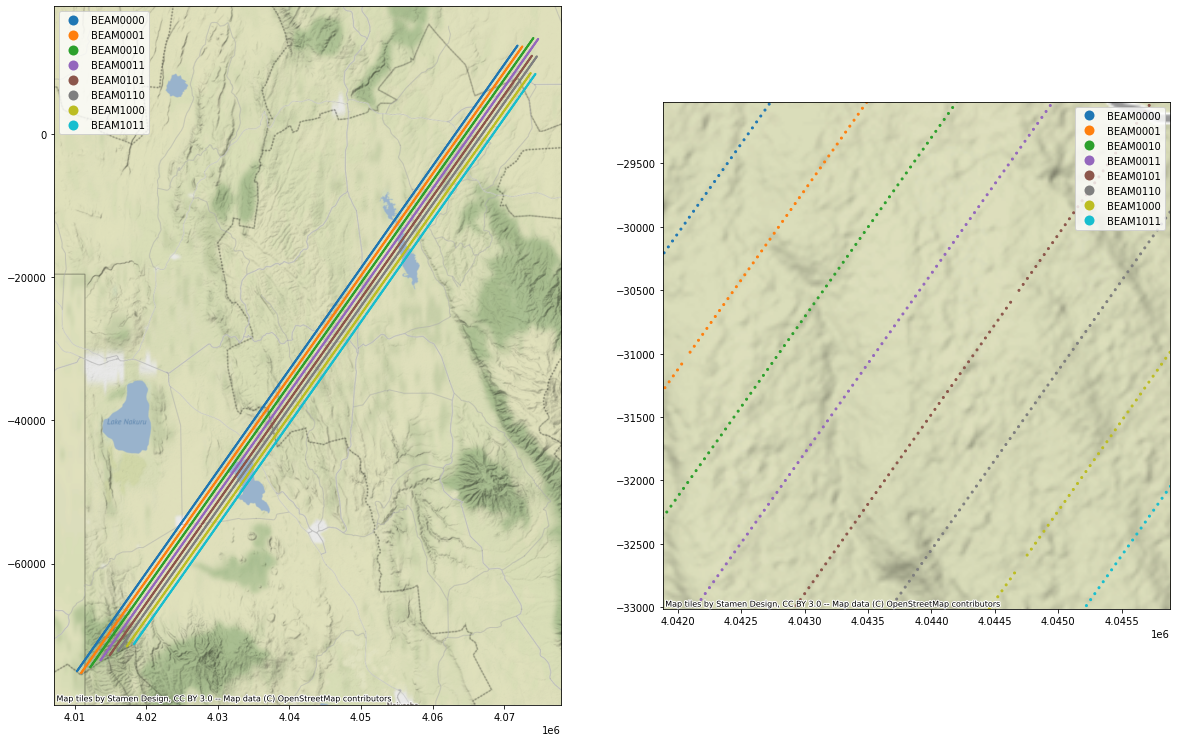

In [26]:
import contextily as ctx
import matplotlib.pyplot as plt

# create figure
_, axes = plt.subplots( figsize=(20,20), ncols=2, nrows=1 )

# plot subset for full area
subset.to_crs(3857).plot( ax=axes[ 0 ], column='beam', legend=True, markersize=1 )
ctx.add_basemap(axes[ 0 ])

# plot subset for postage stamp
subset.to_crs(3857).plot( ax=axes[ 1 ], column='beam', legend=True, markersize=4 )

centroid = subset.to_crs(3857).dissolve().centroid
cx, cy = centroid[ 0 ].x, centroid[ 0 ].y 

axes[ 1 ].set_xlim(cx-2000, cx+2000); axes[ 1 ].set_ylim(cy-2000, cy+2000)
ctx.add_basemap(axes[ 1 ], zoom=13)

In [27]:
from datetime import datetime

# datetime since
origin = datetime(2018, 1, 1, 0, 0, 0)

# min, max  and range datetime 
min_dt = origin + pd.to_timedelta( geoloc.delta_time.min(), unit='s') 
max_dt = origin + pd.to_timedelta( geoloc.delta_time.max(), unit='s') 

range_dt = max_dt - min_dt

# printing 
print_s = f"""Start time: {min_dt}
End time: {max_dt}
Total period: {range_dt}
Total shots: {len(geoloc.index)}"""
print(print_s)

Start time: 2019-04-18 03:33:47.003320
End time: 2019-04-18 03:48:28.965729
Total period: 0:14:41.962409
Total shots: 823009
